In [1]:
%matplotlib inline

In [2]:
import numpy as np

import nengo
from nengo.builder import Builder
from nengo.builder.neurons import SimNeurons
from nengo.builder.signal import SignalDict
from nengo.config import SupportDefaultsMixin
from nengo.connection import ConnectionSolverParam
from nengo.params import Default
from nengo.solvers import Solver, LstsqL2
from nengo.synapses import SynapseParam, Lowpass


class TemporalSolver(Solver, SupportDefaultsMixin):
    """Wraps a solver to simulate the neurons over time."""

    solver = ConnectionSolverParam(
        'solver', default=LstsqL2(), readonly=True)
    synapse = SynapseParam(
        'synapse', default=Lowpass(tau=0.005), readonly=True)

    def __init__(self, solver=Default, synapse=Default):
        # We can't use super here because we need the defaults mixin
        # in order to determine self.solver.weights.
        SupportDefaultsMixin.__init__(self)
        self.solver = solver
        self.synapse = synapse
        Solver.__init__(self, weights=self.solver.weights)

    def mul_encoders(self, *args, **kwargs):
        return self.solver.mul_encoders(*args, **kwargs)

    def __call__(self, A, Y, rng=None, E=None):  # nengo issue #1358
        return self.solver.__call__(A, Y, rng=rng, E=E)


@Builder.register(TemporalSolver)
def build_solver(model, solver, conn, rng, transform):
    # Unpack the relevant variables from the connection.
    assert isinstance(conn.pre_obj, nengo.Ensemble)
    ensemble = conn.pre_obj
    neurons = ensemble.neurons
    neuron_type = ensemble.neuron_type

    # Find the operator that simulates the neurons.
    # We do it this way (instead of using the step_math method)
    # because we don't know the number of state parameters or their shapes.
    ops = list(filter(
        lambda op: (isinstance(op, SimNeurons) and
                    op.J is model.sig[neurons]['in']),
        model.operators))
    if not len(ops) == 1:
        raise RuntimeError("Expected exactly one operator for simulating "
                           "neurons (%s), found: %s" % (neurons, ops))
    op = ops[0]

    # Create stepper for the neuron model.
    signals = SignalDict()
    op.init_signals(signals)
    step_simneurons = op.make_step(signals, model.dt, rng)

    # Create custom rates method that uses the built neurons.
    def override_rates_method(x, gain, bias):
        n_eval_points, n_neurons = x.shape
        assert ensemble.n_neurons == n_neurons

        a = np.empty((n_eval_points, n_neurons))
        for i, x_t in enumerate(x):
            signals[op.J][...] = neuron_type.current(x_t, gain, bias)
            step_simneurons()
            a[i, :] = signals[op.output]
        return solver.synapse.filt(a, axis=0, y0=0, dt=model.dt)

    # Hot-swap the rates method while calling the underlying solver.
    # The solver will then call this temporarily created rates method
    # to process each evaluation point.
    save_rates_method = neuron_type.rates
    neuron_type.rates = override_rates_method
    try:
        # Note: passing solver.solver doesn't actually cause solver.solver
        # to be built. It will still use conn.solver. The only point of
        # passing solver.solver is to invoke its corresponding builder
        # function (in case something custom happens to be registered).
        return model.build(solver.solver, conn, rng, transform)
    finally:
        neuron_type.rates = save_rates_method

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:04.                                                 


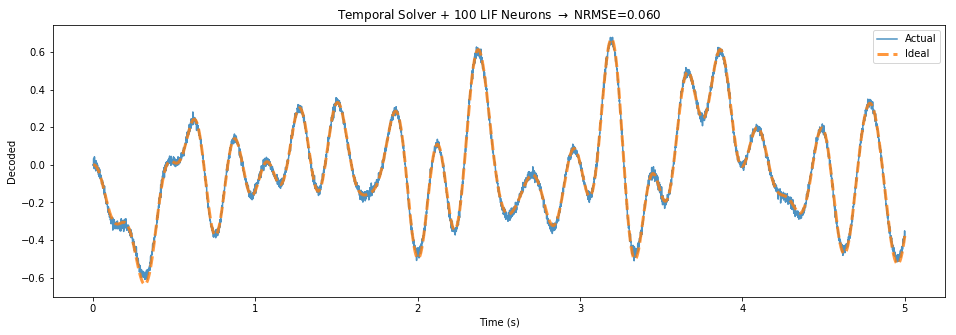

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:03.                                                 


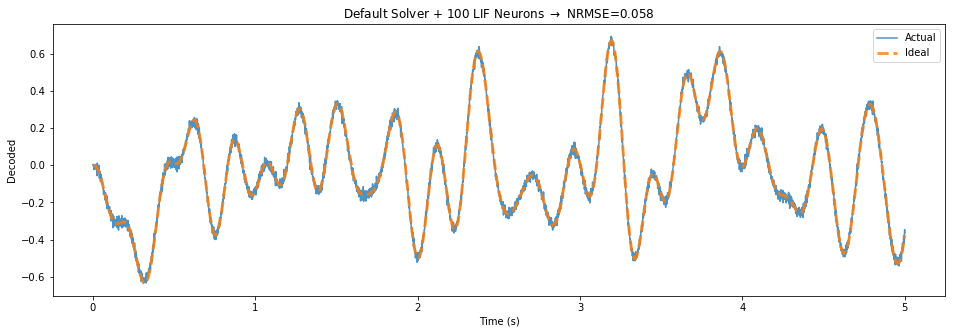

In [3]:
import matplotlib.pyplot as plt
from nengolib.signal import nrmse


def demo(n_neurons=100,
         dimensions=1,
         neuron_type=nengo.LIF(),  # low-threshold spiking (LTS)
         synapse=nengo.Lowpass(0.01),
         train_process=nengo.processes.WhiteSignal(10.0, high=5, y0=0, rms=0.3, seed=0),
         test_process=nengo.processes.WhiteSignal(10.0, high=5, y0=0, rms=0.3, seed=1),
         sim_t=5.0,
         dt=0.001,
         n_eval_points=5000,
         temporal_solver=True):
    """Filtered communication channel demo."""

    kwargs = {'eval_points': train_process.run_steps(n_eval_points, dt=dt, d=dimensions)}
    if temporal_solver:
        kwargs.update({
            'solver': TemporalSolver(synapse=synapse),
            'function': synapse.filt(kwargs['eval_points'], axis=0, y0=0, dt=dt)})

    with nengo.Network() as model:
        stim = nengo.Node(output=test_process, size_out=dimensions)
        x = nengo.Ensemble(n_neurons, dimensions, neuron_type=neuron_type)
        out = nengo.Node(size_in=dimensions)

        nengo.Connection(stim, x, synapse=None)
        nengo.Connection(x, out, synapse=None, **kwargs)

        p = nengo.Probe(out, synapse=synapse)
        ideal = nengo.Probe(stim, synapse=synapse)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(sim_t)

    plt.figure(figsize=(16, 5))
    plt.title(r"%s Solver + %d %s Neurons $\rightarrow$ NRMSE=%.3f" % (
        "Temporal" if temporal_solver else "Default",
        n_neurons, type(neuron_type).__name__,
        nrmse(sim.data[p], target=sim.data[ideal])))
    plt.plot(sim.trange(), sim.data[p], label="Actual", alpha=0.8)
    plt.plot(sim.trange(), sim.data[ideal], label="Ideal",
             linestyle='--', lw=3, alpha=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Decoded")
    plt.legend()
    plt.show()


if __name__ == '__main__':
    demo(temporal_solver=True)
    demo(temporal_solver=False)